<a href="https://colab.research.google.com/github/jugash/Tools/blob/master/1DCNN_BiLSTM(jugash).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import re
import time
from gensim.models import Word2Vec
from gensim.models import FastText
#from gensim.models.wrappers import FastText
from tqdm import tqdm
from pprint import pprint
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
import io
from sklearn.metrics import classification_report
#%matplotlib inline

#uploaded = files.upload()
data_path = '/content/drive/My Drive/DataScience/data.txt'
f = open(data_path, "r")

#print(Sentences[2][1])
df = pd.DataFrame()
Sentences=[]
count=0
for s in f:
    a=0
    d=[]
    count+=1
    if ";" in s:
        '''if s.count(';') != 2:   Finding number of wrongly formatted lines
            print(count)'''
        b = s.split(";")
        b[2] = b[2].lower()
    #print(len(b[2]))
        for x in range(len(b[2])):
            if (b[2][x] == '.' or b[2][x] == '?' or b[2][x] == '!' or b[2][x] == '…'):
                d.append(b[2][a:x])
                a=x+1
        df.loc[count, "Name"] = b[1]
        df.loc[count, "Utterance"] = b[2]


        for x in range(len(d)):
            sent = d[x].translate({ord(i): None for i in ',-.'})
            Sentences.append(sent.split()) # Need to remove non-alphabetical characters from the lists

#df.to_csv('DataTable.csv')
#print(Sentences)

df['Name'] = df['Name'].replace(['Hero', 'Varun', ' Varunu', '06-18:08:Varun', 'varun', ' Varun'], 'Varun')
df['Name'] = df['Name'].replace(['Balraju', 'Bala Raju', 'bala Raju', 'Bala raju', ' Bala Raju'], 'Balraju')
df['Name'] = df['Name'].replace(['Heroine', 'Jagadamba', 'J', 'Jagadhamba', 'Jagdamba', 'Jagadhmba', 'Jagdhamba', ' Jagadhamba', 'Jgadhamba', 'Jagadhama'], 'Jagadamba')
df['Name'] = df['Name'].replace(['krishna', 'Krshna', 'Krishana', 'Kroshna'], 'Krishna')
df['Name'] = df['Name'].replace(['Heroine father', 'Jagadamba father', 'J father', 'Guravayya', 'Guravayy', ' J father', 'Guravyya'], 'Guruvayya') 
df['Name'] = df['Name'].replace(['Heroine grandma', 'Jagadamba grandma', 'J Grand mother', 'Baamma', 'J Grand Mother', 'Grand Mother'], 'J grandma')
df['Name'] = df['Name'].replace(['Boss'], 'Ramesh')
df['Name'] = df['Name'].str.replace('J.s Grand Moyther', 'J grandma', regex=True)
df['Name'] = df['Name'].str.replace('J.s Grand Mother', 'J grandma', regex=True)
df['Name'] = df['Name'].str.replace('Jagadhamba.s Grand Mother', 'J grandma', regex=True)
df['Name'] = df['Name'].str.replace('J.sGrand Mother', 'J grandma', regex=True)
df['Name'] = df['Name'].str.replace('Heroin.s Grand Mother', 'J grandma', regex=True)
df['Name'] = df['Name'].str.replace('Hero-in.s Father', 'Guruvayya', regex=True)
df['Name'] = df['Name'].str.replace('Heroin.s Father', 'Guruvayya', regex=True)
#AllNames = df['Name'].unique().tolist()

Dialogues_by_Speaker = df.groupby("Name")["Utterance"].count().nlargest(40)
print(Dialogues_by_Speaker.head(40))

df.loc[:, 'Labels'] = "Other"
df.loc[df['Name'] == 'Varun', 'Labels'] = "Varun"
df.loc[df['Name'] == 'Balraju', 'Labels'] = "Balraju"
df.loc[df['Name'] == 'Jagadamba', 'Labels'] = "Jagadamba"
df.loc[df['Name'] == 'Krishna', 'Labels'] = "Krishna"
df.loc[df['Name'] == 'Guruvayya', 'Labels'] = "Guruvayya"
df.loc[df['Name'] == 'Ramesh', 'Labels'] = "Ramesh"

print(df.head(20))
#pprint(AllNames)


''' Gensim Word2Vec code 
start_time = time.time()

model =  Word2Vec(sentences=Sentences, size=100, window=5, min_count=3, workers=4, sg=0)
print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')
'''


embedding_dim=300

model = FastText(Sentences, size=embedding_dim, window=5, min_count=1, workers=4, sg=0)
#model = FastText.load_fasttext_format(Sentences)
print(len(model.wv.vocab.keys()))
print(model.wv.vector_size)
#print(model.wv.get_vector('assalu'))
print(model.wv.most_similar('assalu'))
model.wv.save_word2vec_format('FastTextVectorsFinal.txt', fvocab = 'Vocab')



Name
Varun            1232
Jagadamba         715
Krishna           660
Balraju           400
Guruvayya         232
Ramesh            197
Mahesh            168
Ranga             162
J grandma         132
Nikhil            124
Madhur            118
SB                100
Shobhan Babu       91
Baali Reddy        86
Sasmitha           73
Puli               72
Apsara             67
SSK                67
KS                 63
Divya              61
Rambabu            54
J mother           51
Simham             49
Rangi              40
Varun grandma      38
Jack               37
Sai Reddy          37
Sash               36
Kodi Raju          35
Bhavani            34
Varun father       34
Sarayu             33
Sree Reddy         33
Kaveri             31
Boo                30
RSK                29
Barbie             28
EM                 28
Roo                28
Paidiraju          26
Name: Utterance, dtype: int64
               Name  ...     Labels
1          Narrator  ...      Other
3     Man1(Br

In [ ]:
from sklearn.model_selection import train_test_split
#from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

labels = df['Labels'].values
sentences = df['Utterance'].values

#categorical_labels = to_categorical(labels, num_classes=7)
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, labels, test_size = 0.25, random_state=1000)

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=13000, lower=True)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1

In [ ]:
from keras.preprocessing.sequence import pad_sequences

def pad_repeat(A, size=100):
  return np.vstack([np.resize(A[i], size) for i in range(len(A))])

maxlen = 100

X_train=pad_repeat(X_train,maxlen)
X_test=pad_repeat(X_test,maxlen)

X_train = X_train[y_train.argmax(axis=1) != 4]
y_train = y_train[y_train.argmax(axis=1) != 4]
y_train = np.hstack([y_train[:,:4], y_train[:, 5:]])

X_test = X_test[y_test.argmax(axis=1) != 4]
y_test = y_test[y_test.argmax(axis=1) != 4]
y_test = np.hstack([y_test[:,:4], y_test[:, 5:]])


# X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
# X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    
    return embedding_matrix


#uploaded=files.upload()
embedding_matrix = create_embedding_matrix('FastTextVectorsFinal.txt', tokenizer.word_index, embedding_dim)

# New Section

In [ ]:
import tensorflow.keras as keras
import sys

class LossAndErrorPrintingCallback(keras.callbacks.Callback):
    # def on_train_batch_end(self, batch, logs=None):
    #     sys.stdout.write("\rFor batch {}, loss is {:7.2f}.".format(batch, logs["loss"]))

    # def on_test_batch_end(self, batch, logs=None):
    #     sys.stdout.write("\rFor batch {}, loss is {:7.2f}.".format(batch, logs["loss"]))

    def on_epoch_end(self, epoch, logs=None):
        sys.stdout.write("\rEpoch finished {:d}.".format(epoch))


In [ ]:
import numpy as np


class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [ ]:
from keras.models import Sequential, Model
from keras import layers
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks


model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))

model.add(layers.Conv1D(10, kernel_size=3,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(layers.LeakyReLU(alpha=0.2))
model.add(layers.MaxPool1D(pool_size=2))
model.add(SpatialDropout1D(0.5))
# model.add(Flatten())
# model.add(layers.Embedding(vocab_size, embedding_dim, 
#                            weights=[embedding_matrix], 
#                            input_length=maxlen, 
#                            trainable=False))
# model.add(layers.Conv1D(10, kernel_size=8,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
# model.add(layers.LeakyReLU(alpha=0.2))
# model.add(layers.MaxPool1D(pool_size=2))
# model.add(SpatialDropout1D(0.5))
# model.add(Flatten())
model.add(Bidirectional(LSTM(50,dropout=0.5, recurrent_dropout=0.5)))

model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(6,activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          3408000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 10)           9010      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100, 10)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 10)            0         
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 10)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               24400     
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

In [ ]:
# print(y_train.argmax(axis=1))
history = model.fit(X_train, y_train,
                    epochs=1000,
                    verbose=False,
                    validation_split=0.15,
                    batch_size=128,
                    callbacks=[LossAndErrorPrintingCallback()])

'''loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))'''

For batch 3, loss is    1.65.Epoch finished 0. {'loss': 1.5727980136871338, 'accuracy': 0.36902573704719543, 'val_loss': 1.6529594659805298, 'val_accuracy': 0.33766233921051025}
For batch 3, loss is    1.64.Epoch finished 1. {'loss': 1.580381989479065, 'accuracy': 0.36351102590560913, 'val_loss': 1.6420763731002808, 'val_accuracy': 0.34025973081588745}
For batch 3, loss is    1.64.Epoch finished 2. {'loss': 1.576865792274475, 'accuracy': 0.35983455181121826, 'val_loss': 1.6390293836593628, 'val_accuracy': 0.33506494760513306}
For batch 3, loss is    1.64.Epoch finished 3. {'loss': 1.575448751449585, 'accuracy': 0.3602941036224365, 'val_loss': 1.6445332765579224, 'val_accuracy': 0.34025973081588745}
For batch 3, loss is    1.64.Epoch finished 4. {'loss': 1.5758699178695679, 'accuracy': 0.36764705181121826, 'val_loss': 1.6446917057037354, 'val_accuracy': 0.33766233921051025}
For batch 3, loss is    1.63.Epoch finished 5. {'loss': 1.575914740562439, 'accuracy': 0.3658088147640228, 'val_lo

In [ ]:
from scipy import stats
print("[INFO] evaluating network...")
predictions = model.predict(x=X_test, batch_size=20)
predictions.shape

[INFO] evaluating network...


(875, 6)

In [ ]:
y_test.shape

(875, 6)

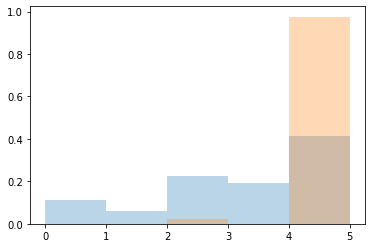

In [ ]:
# plt.plot(predictions)
# plt.show()
z=np.argmax(y_test, axis=1)
z1=np.argmax(predictions, axis=1)
plt.hist(z, density=True, bins=range(6), alpha=0.3)
plt.hist(z1, density=True, bins=range(6), alpha=0.3)
plt.show()

# X_test

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 2 5 5 5 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 2
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 5 5 5 2 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


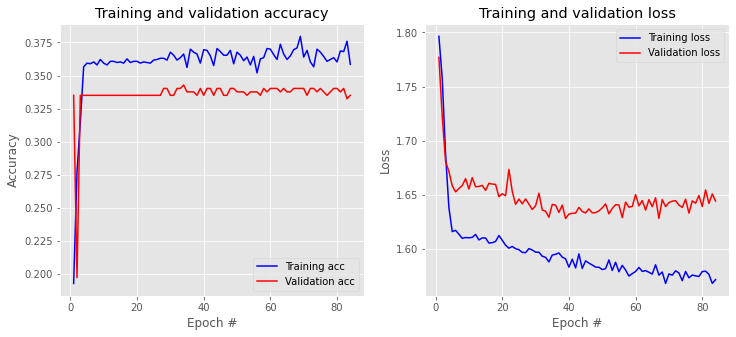

In [ ]:
print(predictions.argmax(axis=1))
print(stats.describe(predictions.argmax(axis=1)))
print(y_test.argmax(axis=1))
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

plt.style.use('ggplot')

def plot_history(history):
    #N = np.arrange(0, 50) #no of Epochs3624131977558136, 'val_loss': 1.6126309633255005, 'val_accuracy': 0.3463034927845001}
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    #plt.savefig(args["plot"])

plot_history(history)

print("[INFO] serializing network and label binarizer...")
#model.save(args["model"], save_format="h5")

In [ ]:
DIS=X_test[:1600, :99].reshape(-1,150,3)
print(DIS.shape)
plt.figure(figsize=(12,18))
plt.imshow(DIS)

In [ ]:
from cv2 import resize
import fastai
from fastai.vision import *
from fastai.callbacks import *

class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = torch.tensor(output,requires_grad=True).cuda()
    def close(self):
        self.hook.remove()

In [ ]:
class FilterVisualizer():
    def __init__(self, size=56, upscaling_steps=12, upscaling_factor=1.2):
        self.size, self.upscaling_steps, self.upscaling_factor = size, upscaling_steps, upscaling_factor
        self.model = models.vgg16_bn(pretrained=True).cuda().eval()
        # set_trainable(self.model, False)

    def visualize(self, layer, filter, lr=0.1, opt_steps=20, blur=None):
        sz = self.size
        img = np.uint8(np.random.uniform(150, 180, (sz, sz, 3)))/255  # generate random image
        activations = SaveFeatures(list(self.model.children())[layer])  # register hook

        for _ in range(self.upscaling_steps):  # scale the image up upscaling_steps times
            train_tfms, val_tfms = tfms_from_model(vgg16, sz)
            img_var = V(val_tfms(img)[None], requires_grad=True)  # convert image to Variable that requires grad
            optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)
            for n in range(opt_steps):  # optimize pixel values for opt_steps times
                optimizer.zero_grad()
                self.model(img_var)
                loss = -activations.features[0, filter].mean()
                loss.backward()
                optimizer.step()
            img = val_tfms.denorm(img_var.data.cpu().numpy()[0].transpose(1,2,0))
            self.output = img
            sz = int(self.upscaling_factor * sz)  # calculate new image size
            img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
            if blur is not None: img = cv2.blur(img,(blur,blur))  # blur image to reduce high frequency patterns
        self.save(layer, filter)
        activations.close()
        
    def save(self, layer, filter):
        plt.imsave("layer_"+str(layer)+"_filter_"+str(filter)+".jpg", np.clip(self.output, 0, 1))



In [ ]:
layer = 40
filter = 265

FV = FilterVisualizer(size=56, upscaling_steps=12, upscaling_factor=1.2)
FV.visualize(layer, filter, blur=5)

img = PIL.Image.open("layer_"+str(layer)+"_filter_"+str(filter)+".jpg")
plt.figure(figsize=(7,7))
plt.imshow(img)

IndexError: ignored